# JigsawHSI for Hyper Spectral Image Classification

**Author:** Jaime MORAGA
**ORCID :** https://orcid.org/0000-0003-4483-9900

# Select dataset

In [6]:
## GLOBAL VARIABLES
dataset = 'PU_100'
# dataset = 'IP_99.74'
# dataset = 'PU_100'
# dataset = 'SA_100'


# Initialize all random functions with same seed

In [7]:
import os
# Use this before loading tensorflow
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # Block INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Block INFO and WARNING messages
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Block INFO, WARNING and ERROR messages
# https://www.tensorflow.org/api_docs/python/tf/autograph/set_verbosity
os.environ["AUTOGRAPH_VERBOSITY"] = "0"
import tensorflow as tf
tf.get_logger().setLevel("WARNING")

import random
import numpy as np

def random_seed():
    return os.urandom(42)

def reset_seeds(random_state = 42):
    try:
        tf.keras.utils.set_random_seed(random_state) # This resets all
        return 0
    except:
        random.seed(random_state)
        np.random.seed(random_state)
        tf.random.set_seed(random_state) # Tensorflow 2.9+
    try:
        from tensorflow import set_random_seed # Tensorflow 1.x
        set_random_seed(random_state)
        return 2
    except:
        pass
    return 1

max_gpus = len(tf.config.list_physical_devices('GPU'))

"""
Reset all random seeds
"""
r = reset_seeds(345)
del r

# Import libraries

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis, NMF
from sklearn.decomposition import PCA, TruncatedSVD
from operator import truediv

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

#!pip install spectral
import spectral

# Define functions

## JigsawHSI definition

In [9]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adadelta, SGD, Adam, Nadam, Adagrad, Adamax

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils as np_utils

from skimage.transform import rotate
from tensorflow.keras.models import clone_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import multi_gpu_model

def jigsaw_m2( input_net, first_layer = None , internal_size = 13):
    # Creates internal filters as Inception: 1x1, 3x3, 5x5 ..., nxn 
    # Where n = internal_size
    jigsaw_t1_1x1 = Conv2D(256, (1,1), padding='same', activation = 'relu', 
                           kernel_regularizer = l2(0.002))(input_net)
    jigsaw_t1_3x3_reduce = Conv2D(96, (1,1), padding='same', activation = 'relu', 
                                  kernel_regularizer = l2(0.002))(input_net)
    jigsaw_t1_3x3 = Conv2D(128, (3,3), padding='same', activation = 'relu', 
                           kernel_regularizer = l2(0.002))(jigsaw_t1_3x3_reduce) # , name="i_3x3"
    if (internal_size >= 5):
        jigsaw_t1_5x5_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_5x5 = Conv2D(128, (5,5), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(0.002))(jigsaw_t1_5x5_reduce) # , name="i_5x5"
    if (internal_size >= 7):
        jigsaw_t1_7x7_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_7x7 = Conv2D(128, (7,7), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(0.002))(jigsaw_t1_7x7_reduce) # , name="i_7x7"
    if (internal_size >= 9):
        jigsaw_t1_9x9_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_9x9 = Conv2D(64, (9,9), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(0.002))(jigsaw_t1_9x9_reduce) # , name="i_9x9"
    if (internal_size >= 11):
        jigsaw_t1_11x11_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                        kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_11x11 = Conv2D(64, (11,11), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(jigsaw_t1_11x11_reduce) # , name="i_11x11"
    if (internal_size >= 13):
        jigsaw_t1_13x13_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                        kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_13x13 = Conv2D(64, (13,13), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(jigsaw_t1_13x13_reduce) # , name="i_13x13"
    jigsaw_t1_pool = MaxPooling2D(pool_size=(3,3), strides = (1,1), padding='same')(input_net)
    jigsaw_t1_pool_proj = Conv2D(32, (1,1), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(jigsaw_t1_pool)
    jigsaw_list = [jigsaw_t1_1x1, jigsaw_t1_3x3]
    if (internal_size >= 5):
        jigsaw_list.append(jigsaw_t1_5x5)
    if (internal_size >= 7):
        jigsaw_list.append(jigsaw_t1_7x7)
    if (internal_size >= 9):
        jigsaw_list.append(jigsaw_t1_9x9)
    if (internal_size >= 11):
        jigsaw_list.append(jigsaw_t1_11x11)
    if (internal_size >= 13):
        jigsaw_list.append(jigsaw_t1_13x13)
    jigsaw_list.append(jigsaw_t1_pool_proj)
    if first_layer is not None:
        jigsaw_t1_first = Conv2D(96, (1,1), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(first_layer)
        jigsaw_list.append(jigsaw_t1_first)
    jigsaw_t1_output = Concatenate(axis = -1)(jigsaw_list)
    return jigsaw_t1_output

def jigsaw_m_end(input_net, num_classes, first_layer = None):
    avg_pooling = AveragePooling2D(pool_size=(3,3), strides=(1,1), name='avg_pooling')(input_net)
    flat = Flatten()(avg_pooling)
    flat = Dense(16, kernel_regularizer=l2(0.002))(flat)
    flat = Dropout(0.4)(flat)
    if first_layer is not None:
        input_pixel = Flatten()(first_layer)
        input_pixel = Dense(16, kernel_regularizer=l2(0.002))(input_pixel)
        input_pixel = Dropout(0.2)(input_pixel)
        input_pixel = Dense(16, kernel_regularizer=l2(0.002))(input_pixel)
        input_pixel = Dropout(0.2)(input_pixel)
        flat = Concatenate(axis = -1)([input_pixel, flat])
    flat = Dense(32, kernel_regularizer=l2(0.002))(flat)
    avg_pooling = Dropout(0.4)(flat)
    loss3_classifier = Dense(num_classes, kernel_regularizer=l2(0.002))(avg_pooling)
    loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)
    return loss3_classifier_act


# Builds model
def build_jigsawHSI(internal_size=13, num_classes=2, image_dim = (19, 19, 7), dimension_filters = None, verbose=1):
    my_input = Input( shape=image_dim )
    
    # Not needed for SA
    if ((dimension_filters is None) or (dimension_filters < 1)):
        conv1 = None
    else:
        conv1 = Conv2D(dimension_filters, (1,1), padding='same', activation = 'relu',
                      kernel_regularizer = l2(0.002), name='spectral_filter')(my_input)
    if(verbose>0):
        print(f"*** Building Jigsaw with up to {internal_size}x{internal_size} kernels")
    # One jigsaw module(s)
    jigsaw_01 = jigsaw_m2( my_input if conv1 is None else conv1, internal_size = internal_size )
    # For SA, the next two lines must be uncommented
    # jigsaw_01 = jigsaw_m2( jigsaw_01, first_layer=my_input, internal_size = internal_size )
    # jigsaw_01 = jigsaw_m2( jigsaw_01, internal_size = internal_size )
    
    # Attaches end to jigsaw modules, returns class within num_classes
    loss3_classifier_act = jigsaw_m_end(jigsaw_01,
                                    num_classes = num_classes,
                                    first_layer = my_input ) # testing num_classes
    model3 = Model( inputs = my_input, outputs = loss3_classifier_act )
    model3.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    return model3


In [10]:
class Kernel3D:
    def __init__(self, rows=3, cols=3, shape='rect', radius=None, no_value=np.NaN):
        if shape == 'circle':
            self.rows = 2*radius+1
            self.cols = 2*radius+1
            self.mask = self.round_mask(radius)
            self.row_buffer = radius
            self.col_buffer = radius
        else:
            self.rows = rows
            self.cols = cols
            self.mask = np.ones((rows, cols))
            self.row_buffer = int((rows-1)/2)
            self.col_buffer = int((cols-1)/2)
        self.mask = self.mask[np.newaxis, :, :]
        self.no_value = no_value
        assert((rows%2) == 1)
        assert((cols%2) == 1)

    def round_mask(self, radius):
        diameter = 2*radius+1
        mask = np.empty((diameter, diameter,))
        mask[:] = self.no_value
        sq_radius = radius**2
        for i in range(diameter):
            for j in range(diameter):
                if ((i-radius)**2+(j-radius)**2) <= sq_radius:
                    mask[i, j] = 1
        return mask

    def getSubset(self, matrix, row, column):
        m_rows = matrix.shape[1]
        assert (row >= self.row_buffer), f"Out of bounds row {row}, from {m_rows}"
        assert (row < (m_rows-self.row_buffer)), f"Out of bounds row {row}, from {m_rows}"
        m_cols = matrix.shape[2]
        assert((column >= self.col_buffer) and (column < (m_cols-self.col_buffer))), f"Out of bounds column {column}, from {m_cols}"
        row_start = row-self.row_buffer
        row_end = row+self.row_buffer
        column_start = column-self.col_buffer
        column_end = column+self.col_buffer
        small_matrix = matrix[:, row_start:row_end+1, column_start:column_end+1]
        return small_matrix*self.mask

class GeoTiffSlicer(object):
    def __init__(self, land_matrix, kernel_rows=None, kernel_cols=None,
                 kernel_shape='rect', kernel_radius=0, no_value = np.NaN):
        # (w, h, d) input tiff expected
        # (d, h, w) input tiff from rasterio must be transposed before calling this class
        if kernel_cols is None:
            kernel_cols = kernel_rows
        assert(kernel_cols < land_matrix.shape[2])
        assert(kernel_rows < land_matrix.shape[1])
        assert((kernel_shape == 'rect') or (kernel_shape == 'circle'))
        assert(kernel_radius>=0)
        if kernel_shape == 'rect':
            self.kernel = Kernel3D(rows=kernel_rows, cols=kernel_cols)
        else:
            self.kernel = Kernel3D(radius=kernel_radius,
                                   shape=kernel_shape,
                                   no_value=no_value)
            kernel_rows = kernel_cols = 2*kernel_radius+1
        self.kernel_rows = kernel_rows
        self.kernel_cols = kernel_cols
        self.land_matrix = land_matrix
        self.land_matrix_channels, self.land_matrix_cols, self.land_matrix_rows = land_matrix.shape
        self.land_matrix_cols = land_matrix.shape[2]
        self.land_matrix_rows = land_matrix.shape[1]
        self.land_matrix_channels = land_matrix.shape[0]
        self.small_row_min = self.kernel.row_buffer
        self.small_row_max = self.land_matrix_rows - self.small_row_min
        self.small_column_min = self.kernel.col_buffer
        self.small_column_max = self.land_matrix_cols - self.small_column_min

    def apply_mask(self, row, column):
        return self.kernel.getSubset(self.land_matrix, row=row, column=column)

## Decompostion functions: reduce dimensionality

In [11]:
# Dimensionality reduction algorithms
def applyPCA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    pca = PCA(n_components=numComponents, whiten=True, random_state=random_state)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'pca'

def applyFA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    fa = FactorAnalysis(n_components=numComponents, random_state=random_state)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'fa'

def applySVD(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    svd = TruncatedSVD(n_components=numComponents, random_state=random_state)
    newX = svd.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'svd'

def applyNMF(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    nmf = NMF(n_components=numComponents, random_state=random_state)
    newX = nmf.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'nmf'

def applyNone(X, numComponents=75, random_state=0):
    return X, 'None'


## Utilitary functions

In [12]:
def readData(dataset, data_path='./data'):
    data_dict = {
        'IP': ('Indian_pines_corrected.mat', 'indian_pines_corrected', 'Indian_pines_gt.mat', 'indian_pines_gt'),
        'SA': ('Salinas_corrected.mat', 'salinas_corrected', 'Salinas_gt.mat', 'salinas_gt'),
        'PU': ('PaviaU.mat', 'paviaU', 'PaviaU_gt.mat', 'paviaU_gt')
    }
    (X_1, X_2, y_1, y_2) = data_dict.get(dataset[0:2].upper())
    X = sio.loadmat(os.path.join(data_path, X_1))[X_2]
    y = sio.loadmat(os.path.join(data_path, y_1))[y_2]
    
    return (X, y)


In [13]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [14]:
# Padding functions
def padWithZeros(X, margin=2):
    newX = np.pad(X, pad_width=((margin, margin),(margin, margin),(0, 0)), constant_values = 0)
    return newX

def padSymmetric(X, margin=2):
    newX = np.pad(X, pad_width=((margin, margin),(margin, margin),(0, 0)), mode = 'symmetric')
    return newX




In [15]:
def createImageCubes(X, y, window_size=8, removeZeroLabels = True):
    margin = int((window_size-1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1 , c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

# Load parameters from config file (config.ini)

In [16]:
import configparser
config = configparser.ConfigParser(inline_comment_prefixes=';#')
config.read_file(open('config.ini'))
config = config[dataset]

In [17]:
# Parse parameters and hyper-parameters from config file

test_ratio   = config.getfloat('test_ratio', 0.9)
window_size  = config.getint('window_size', 25)
num_channels = config.getint('num_channels', 3)
output_units = config.getint('output_units', 16)

filter_size  = config.getint('filter_size', 13)

batch_size   = config.getint('batch_size', 30)
max_epochs   = config.getint('max_epochs', 100)

decomp_func  = config.get('decomp_func', 'pca').lower()
optimizer_fn = config.get('optimizer_fn', 'sgd').lower()
optimizer_lr = config.getfloat('optimizer_lr', 0.01)
max_patience = config.getint('max_patience', 10)

hsi_filters  = config.get('hsi_filters', 'none')
hsi_filters  = None if (hsi_filters.lower() in ['none', '']) else int(hsi_filters)
print(hsi_filters)

512


## Select proper optimizer and decomposition functions

In [18]:
dict_reduction={
    'fa' : (lambda X, numComponents: applyFA(X, numComponents=numComponents)),
    'nmf' : (lambda X, numComponents: applyNMF(X, numComponents=numComponents)),
    'pca': (lambda X, numComponents: applyPCA(X, numComponents=numComponents)),
    'svd': (lambda X, numComponents: applySVD(X, numComponents=numComponents)),
    'none': (lambda X, numComponents: applyNone(X, numComponents=numComponents))
}

DimReduction=dict_reduction.get(decomp_func)

dict_optimizer = {
    'sgd'     : SGD(learning_rate=optimizer_lr, momentum=0.9, nesterov=False),
    'adadelta': Adadelta(learning_rate=optimizer_lr, rho=0.95, epsilon=1e-07),
    'adam'    : Adam(learning_rate=optimizer_lr, epsilon=1e-07),
    'nadam'   : Nadam(learning_rate=optimizer_lr, epsilon=1e-07),
    'adamax'  : Adamax(learning_rate=optimizer_lr, epsilon=1e-07),
    'adagrad' : Adagrad(learning_rate=optimizer_lr, epsilon=1e-07)
}

FuncOptimizer = dict_optimizer.get(optimizer_fn)

In [19]:
# Define names of output files
best_model          = dataset + '-best-model.hdf5'
loss_curve          = dataset + '-loss-curve.png'
acc_curve           = dataset + '-acc-curve.png'
classification_file = dataset + '-classification_report.txt'
predictions_img     = dataset + '-predictions.png'
architecture_img    = dataset + '-architecture.png'

In [20]:
HSI, HSI_y = readData(dataset[0:2].upper())

HSI.shape, HSI_y.shape

((610, 340, 103), (610, 340))

In [21]:
num_channels = np.min([HSI.shape[2], num_channels])

In [22]:
DRI, dim_reduction = DimReduction(HSI,numComponents=num_channels)

num_channels = DRI.shape[2]
DRI.shape

(610, 340, 9)

In [23]:
X, y = createImageCubes(DRI, HSI_y, window_size=window_size)

X.shape, y.shape

((42776, 25, 25, 9), (42776,))

In [24]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12832, 25, 25, 9), (29944, 25, 25, 9), (12832,), (29944,))

In [25]:
Xtrain = Xtrain.reshape(-1, window_size, window_size, num_channels) #, 1)
Xtrain.shape

(12832, 25, 25, 9)

In [26]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(12832, 9)

# Build network

In [27]:

input_shape =  (window_size, window_size, num_channels)
model = clone_model(build_jigsawHSI(internal_size = filter_size,
                      num_classes = output_units,
                      verbose=1,
                      dimension_filters=hsi_filters, # Was None,
                      image_dim = input_shape))

*** Building Jigsaw with up to 9x9 kernels


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 25, 9)]  0                                            
__________________________________________________________________________________________________
spectral_filter (Conv2D)        (None, 25, 25, 512)  5120        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 25, 96)   49248       spectral_filter[0][0]            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 25, 25, 16)   8208        spectral_filter[0][0]            
______________________________________________________________________________________________

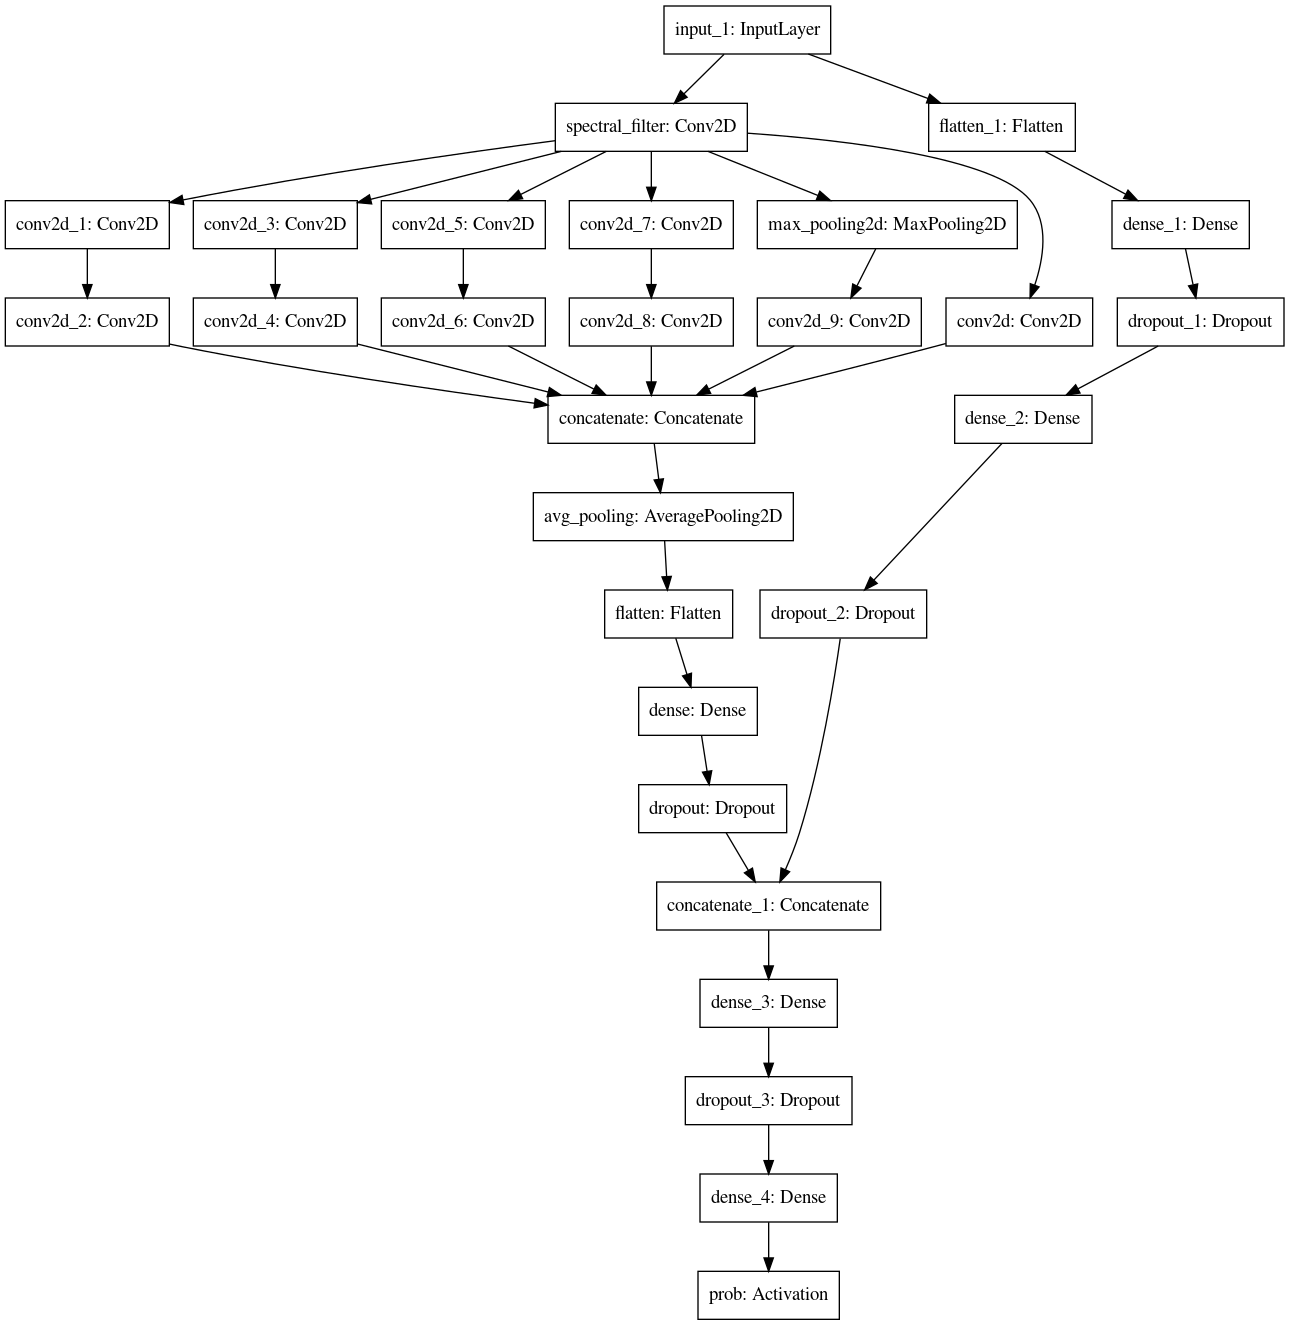

In [28]:
model.summary()
plot_model(model)
plot_model(model, to_file=architecture_img)

In [29]:
# Parallelize if gpus > 1
if (max_gpus>1):
    model = multi_gpu_model(model, gpus=max_gpus)
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=FuncOptimizer, metrics=['accuracy'])

In [30]:
# Saves the best model, based on accuracy
checkpoint = ModelCheckpoint(best_model, monitor='accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [31]:
# If no early stopping desired, skip this cell
early_stop = EarlyStopping( monitor = 'loss',
                           min_delta=0.001,
                           mode='auto',
                           verbose=1, patience=max_patience)
callbacks_list = [checkpoint, early_stop]

In [32]:
# Summarize configuration
config_txt  = f'Configuration for dataset [{dataset}]:\n\n'
config_txt += f'Test Set Ratio: {test_ratio*100}% of samples\n'
config_txt += f'Window Size   : {window_size} pixels per side\n'
config_txt += f'Dim. Reduction: {dim_reduction} function\n'
config_txt += f'Num channels  : {num_channels} bands after {dim_reduction}\n'
config_txt += '# Network design\n'
config_txt += f'Input shape   : ({window_size}x{window_size}x{num_channels})\n'
config_txt += f'HSI Filters   : {hsi_filters} filters in first layer\n'
config_txt += f'Internal Size : ({filter_size}x{filter_size}) maximum network filter size\n'
config_txt += '# Training hyperparameters\n'
config_txt += f'Optimizer     : {optimizer_fn}\n'
config_txt += f'Learning rate : {optimizer_lr}\n'
config_txt += f'Batch Size    : {batch_size}\n'
config_txt += f'Num Epochs    : {max_epochs}\n' 
config_txt += f'Patience      : {max_patience}\n'
config_txt += '# Training GPUs\n'
config_txt += f'GPU Maximum   : {max_gpus}\n'
print(config_txt)

Configuration for dataset [PU_100]:

Test Set Ratio: 70.0% of samples
Window Size   : 25 pixels per side
Dim. Reduction: svd function
Num channels  : 9 bands after svd
# Network design
Input shape   : (25x25x9)
HSI Filters   : 512 filters in first layer
Internal Size : (9x9) maximum network filter size
# Training hyperparameters
Optimizer     : adadelta
Learning rate : 0.1
Batch Size    : 120
Num Epochs    : 500
Patience      : 40
# Training GPUs
GPU Maximum   : 1



In [34]:
# Fit the model keeping the history
history = model.fit(x=Xtrain, y=ytrain, batch_size=batch_size, epochs=1, callbacks=callbacks_list)

107/107 [==============================] - ETA: 0s - loss: 1146.7102 - accuracy: 0.6785
Epoch 00001: accuracy improved from 0.51177 to 0.67854, saving model to PU_100-best-model.hdf5
107/107 [==============================] - 5s 47ms/step - loss: 1146.7102 - accuracy: 0.6785


# Validation

In [35]:
# Saves, but does not display, the history charts
fig = plt.figure(figsize=(7,7)) 
plt.ioff()
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig(loss_curve) 
plt.close(fig)

fig = plt.figure(figsize=(7,7)) 
plt.ioff()
plt.ylim(np.min(history.history['accuracy']),1.05) 
plt.grid() 
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig(acc_curve) 
plt.close(fig) 

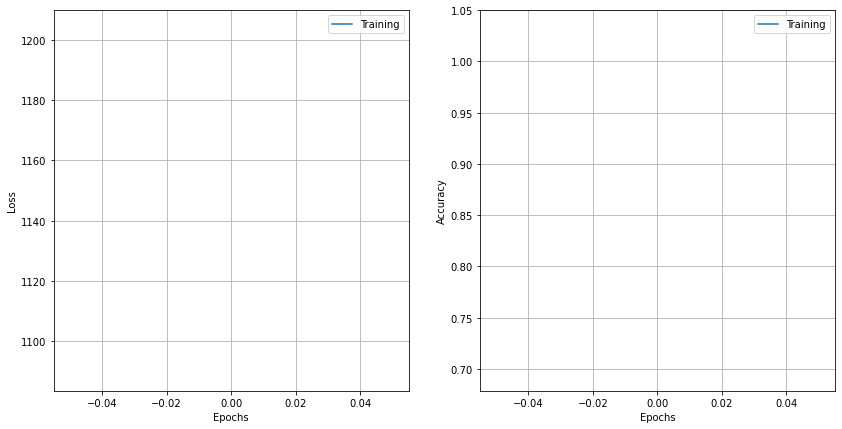

In [36]:
# Displays history of training
# loss and accuracy by epoch, side by side

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))
ax1.grid() 
ax1.plot(history.history['loss'])
ax1.set_ylabel('Loss') 
ax1.set_xlabel('Epochs') 
ax1.legend(['Training','Validation'], loc='upper right') 

ax2.set_ylim(np.min(history.history['accuracy']),1.05) 
ax2.grid() 
ax2.plot(history.history['accuracy'])
ax2.set_ylabel('Accuracy') 
ax2.set_xlabel('Epochs') 
ax2.legend(['Training','Validation']) 
plt.show() # plt.tight_layout()

In [37]:
# load best weights
model.load_weights(best_model)
model.compile(loss='categorical_crossentropy', optimizer=FuncOptimizer, metrics=['accuracy'])

In [38]:
Xtest = Xtest.reshape(-1, window_size, window_size, num_channels) #, 1)
Xtest.shape

(29944, 25, 25, 9)

In [39]:
Ytest = np_utils.to_categorical(ytest)
Ytest.shape

(29944, 9)

In [40]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)


In [41]:
print(y_pred_test.shape) 
classification = classification_report(np.argmax(Ytest, axis=1), y_pred_test)
print(classification)

(29944,)
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4642
           1       0.84      1.00      0.91     13055
           2       0.90      0.72      0.80      1469
           3       0.97      0.94      0.96      2145
           4       0.98      1.00      0.99       942
           5       0.99      0.37      0.54      3520
           6       0.89      0.79      0.84       931
           7       0.91      0.83      0.87      2577
           8       0.96      0.97      0.97       663

    accuracy                           0.88     29944
   macro avg       0.93      0.84      0.87     29944
weighted avg       0.89      0.88      0.87     29944



In [42]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_row_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_row_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [43]:
def get_targets(name):
    targets_dict = {
        'IP': ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
               'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 
               'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'],
        'SA': ['Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 'Stubble',
               'Celery','Grapes_untrained', 'Soil_vinyard_develop', 'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk',
               'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained',
               'Vinyard_vertical_trellis'],
        'PU': ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks',
               'Shadows']
    }
    targets = targets_dict.get(name)
    return (targets)


print(', '.join(get_targets(dataset[0:2].upper())))

def reports (model, X_test, y_test, name, y_pred = None):
    #start = time.time()
    if (y_pred is None):
        Y_pred = model.predict(X_test)
        y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    target_names = get_targets(name[0:2].upper())
    print("Producing report")
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100, target_names

Asphalt, Meadows, Gravel, Trees, Painted metal sheets, Bare Soil, Bitumen, Self-Blocking Bricks, Shadows


In [44]:
(classification, confusion, Test_loss, Test_accuracy, 
 oa, each_acc, aa, kappa, target_names) = reports(model, Xtest, Ytest, dataset[0:2], y_pred=y_pred_test)

Producing report
936/936 [==============================] - 5s 6ms/step - loss: 265.1746 - accuracy: 0.8809


In [45]:
target_performance = 'Accuracy by target:\n'
for (a, b) in zip(target_names, each_acc):
    target_performance += f'{b:8.4f} : {a}\n'
print(target_performance)

Accuracy by target:
 96.3809 : Asphalt
 99.8774 : Meadows
 72.0218 : Gravel
 94.4988 : Trees
100.0000 : Painted metal sheets
 37.3295 : Bare Soil
 78.8400 : Bitumen
 83.1975 : Self-Blocking Bricks
 97.4359 : Shadows



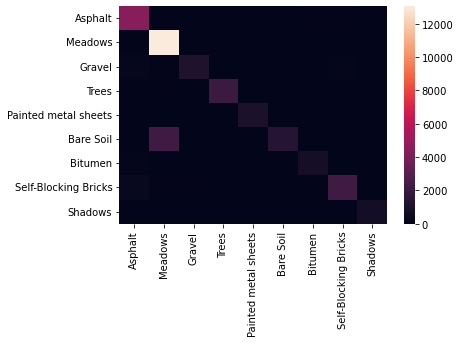

In [46]:
import seaborn as sns
cf_matrix = np.asarray(confusion)
sns_plot=sns.heatmap(cf_matrix, annot=False, xticklabels=target_names, yticklabels=target_names)
sns_plot.figure.savefig(str(dataset)+'-heatmap.png', dpi=600)
#plt.savefig(str(dataset)+'-heatmap.png')

In [47]:
classification = str(classification)
confusion = str(confusion)
confusion=confusion.replace('\n', '')
confusion=confusion.replace('] [', ']\n[')
confusion=confusion.replace('][', ']\n[')
dim_reduction='pca'
c_summary = 'Classification Summary\n'
c_summary += f'{Test_loss:7.3f} Test loss (%)\n'
c_summary += f'{Test_accuracy:7.3f} Test accuracy (%)\n'
c_summary += f'{kappa:7.3f} Kappa accuracy (%)\n'
c_summary += f'{oa:7.3f} Overall accuracy (%)\n'
c_summary += f'{aa:7.3f} Average accuracy (%)\n\n'

c_summary += f'{classification}\n\n'
c_summary += f'{confusion}\n\n'

model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x)) # line_length=70,
model_summary = '\n'.join(model_summary)
model_summary += '\n\n'

print(c_summary)
print(target_performance+'\n\n')
print(model_summary)
print(config_txt)

with open(classification_file, 'w') as cs_file:
    cs_file.write(c_summary)
    cs_file.write(target_performance+'\n\n')
    cs_file.write(model_summary)
    cs_file.write(config_txt)

Classification Summary
26517.459 Test loss (%)
 88.091 Test accuracy (%)
 83.619 Kappa accuracy (%)
 88.091 Overall accuracy (%)
 84.398 Average accuracy (%)

                      precision    recall  f1-score   support

             Asphalt       0.88      0.96      0.92      4642
             Meadows       0.84      1.00      0.91     13055
              Gravel       0.90      0.72      0.80      1469
               Trees       0.97      0.94      0.96      2145
Painted metal sheets       0.98      1.00      0.99       942
           Bare Soil       0.99      0.37      0.54      3520
             Bitumen       0.89      0.79      0.84       931
Self-Blocking Bricks       0.91      0.83      0.87      2577
             Shadows       0.96      0.97      0.97       663

            accuracy                           0.88     29944
           macro avg       0.93      0.84      0.87     29944
        weighted avg       0.89      0.88      0.87     29944


[[ 4474    24    22     1     3

In [48]:
def Patch(data, height_index, width_index, PATCH_SIZE):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [49]:
height = HSI_y.shape[0]
width  = HSI_y.shape[1]

In [50]:
X = padWithZeros(DRI, window_size//2)

In [51]:
X.shape

(634, 364, 9)

In [74]:
from tqdm import tqdm
# calculate the predicted image
outputs = np.zeros((height,width))
#for i in range(height):
for i in tqdm(range(height), desc="Predicting...",
                          ascii=False, ncols=75):
    for j in range(width):
        target = int(HSI_y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X, i, j, window_size)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Predicting...: 100%|█████████████████████| 610/610 [11:53<00:00,  1.17s/it]


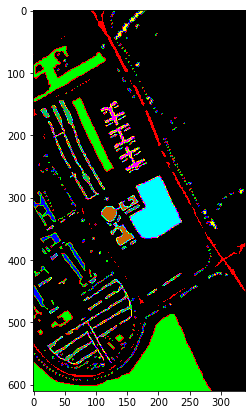

In [75]:
ground_truth = spectral.imshow(classes = HSI_y,figsize =(7,7))

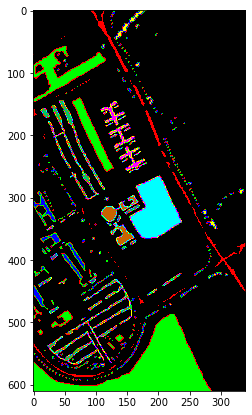

In [76]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

Misclassified pixels:  1 / 207400


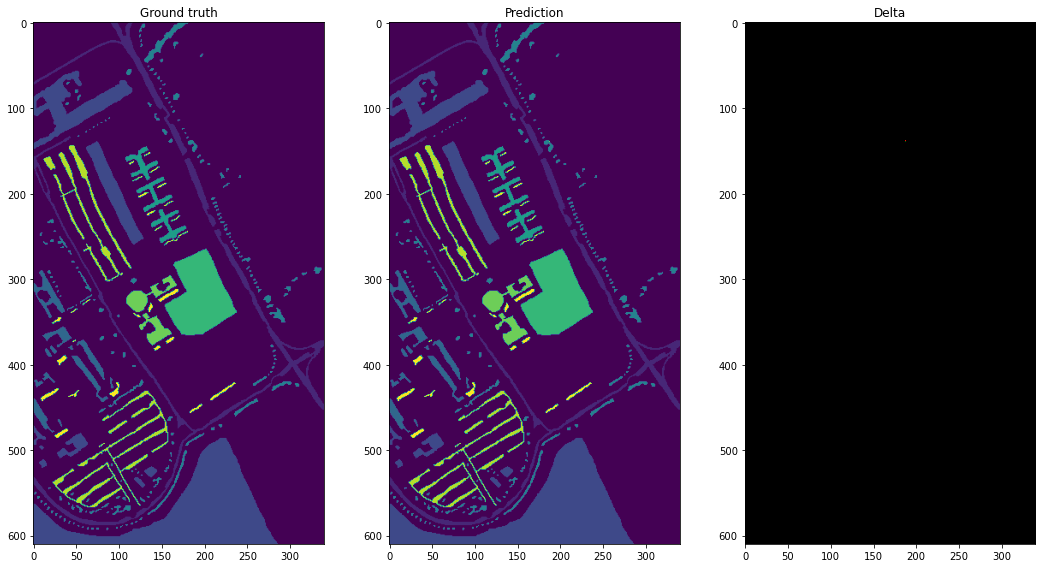

In [77]:
from matplotlib.colors import ListedColormap, NoNorm

cm = ListedColormap(np.array(spectral.spy_colors)/255.0)
delta = (np.abs(outputs.astype(int) - HSI_y)>0)*1
print('Misclassified pixels: ', np.sum(np.asarray(delta)>0), "/", delta.shape[0]*delta.shape[1])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,8))
ax1.set_title("Ground truth")
ax2.set_title("Prediction")
ax3.set_title("Delta")
ax1.imshow(HSI_y) #, cmap=cm, norm=NoNorm())
ax2.imshow(outputs.astype(int)) #, cmap=cm, norm=NoNorm())
ax3.imshow(delta, cmap=cm)
plt.tight_layout()

In [78]:
spectral.save_rgb(str(dataset)+"-ground_truth.png", HSI_y, colors=spectral.spy_colors)
spectral.save_rgb(str(dataset)+"-delta.png", delta, colors=spectral.spy_colors)
spectral.save_rgb(predictions_img, outputs.astype(int), colors=spectral.spy_colors)

In [51]:
#del model
#print("Keras Backend RESET")  # optional
#import keras
#import gc
#keras.backend.clear_session()
#tf.keras.backend.clear_session()
#gc.collect()